In [1]:
# Machine learning 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import datetime as dt
import yfinance as yf
from sklearn.tree import plot_tree

# For data manipulation 
import pandas as pd 
import numpy as np 
  
# To plot 
import matplotlib.pyplot as plt 
  
# To ignore warnings 
import warnings 
warnings.filterwarnings("ignore")

In [2]:
tickers = ['AAPL']

#choose the start  and enddate:
start = dt.datetime.now() - dt.timedelta(730)
end = dt.datetime.now()

#import daily closiing prices
prices = []

#create a dataframe

df = pd.DataFrame(yf.download(tickers, start, end, interval="1d"))
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-09-23,151.190002,151.470001,148.559998,150.429993,148.781525,96029900
2022-09-26,149.660004,153.770004,149.639999,150.770004,149.117798,93339400
2022-09-27,152.740005,154.720001,149.949997,151.759995,150.096954,84442700
2022-09-28,147.639999,150.639999,144.839996,149.839996,148.197998,146691400
2022-09-29,146.100006,146.720001,140.679993,142.479996,140.918655,128138200
...,...,...,...,...,...,...
2024-09-16,216.539993,217.220001,213.919998,216.320007,216.320007,59357400
2024-09-17,215.750000,216.899994,214.500000,216.789993,216.789993,45519300
2024-09-18,217.550003,222.710007,217.539993,220.690002,220.690002,59894900


# Predictors

In [3]:
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def weighted_moving_average(prices, weights):
    weighted_moving_averages = []
    for i in range(len(prices) - len(weights) + 1):
        weighted_sum = sum(prices[i+j] * weights[j] for j in range(len(weights)))
        weighted_moving_averages.append(weighted_sum / sum(weights))
    return pd.Series(weighted_moving_averages, index=prices.index[len(weights)-1:])

def calculate_atr(data, period=14):
    data['HL'] = data['High'] - data['Low']
    data['HC'] = abs(data['High'] - data['Close'].shift())
    data['LC'] = abs(data['Low'] - data['Close'].shift())
    data['TR'] = data[['HL', 'HC', 'LC']].max(axis=1)
    atr = data['TR'].rolling(window=period).mean()
    return atr

def calculate_adx(data, period=14):
    data['High-Low'] = data['High'] - data['Low']
    data['High-PreviousClose'] = abs(data['High'] - data['Close'].shift())
    data['Low-PreviousClose'] = abs(data['Low'] - data['Close'].shift())

    # True Range (TR)
    data['TR'] = data[['High-Low', 'High-PreviousClose', 'Low-PreviousClose']].max(axis=1)

    # Plus Directional Movement (+DM) and Minus Directional Movement (-DM)
    data['+DM'] = (data['High'] - data['High'].shift(1)).apply(lambda x: x if x > 0 else 0)
    data['-DM'] = (data['Low'].shift(1) - data['Low']).apply(lambda x: x if x > 0 else 0)

    # Calculate True Range (TR) and Directional Movement Index (DX)
    data['ATR'] = data['TR'].rolling(window=period).mean()
    data['+DI'] = (data['+DM'].rolling(window=period).mean() / data['ATR']) * 100
    data['-DI'] = (data['-DM'].rolling(window=period).mean() / data['ATR']) * 100

    # Calculate Directional Movement Index (DX)
    data['DX'] = (abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI'])) * 100

    # Calculate ADX
    data['ADX'] = data['DX'].rolling(window=period).mean()

    return data['ADX']

def calculate_vwap(data):
    # Calculate typical price
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    
    # Calculate volume weighted typical price
    vwap = (typical_price * data['Volume']).cumsum() / data['Volume'].cumsum()
    
    return vwap

def calculate_macd_histogram(data, short_window=12, long_window=26, signal_window=9):
    # Calculate short and long exponential moving averages (EMAs)
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    
    # Calculate MACD line
    data['MACD'] = short_ema - long_ema
    
    # Calculate signal line
    data['Signal'] = data['MACD'].ewm(span=signal_window, min_periods=1, adjust=False).mean()
    
    # Calculate MACD histogram
    data['MACD_Histogram'] = data['MACD'] - data['Signal']
    
    return data['MACD_Histogram']

def calculate_moving_average_crossing_status(data, fast_period, slow_period):
    # Calculate fast and slow moving averages
    data['Fast_MA'] = data['Close'].rolling(window=fast_period, min_periods=1).mean()
    data['Slow_MA'] = data['Close'].rolling(window=slow_period, min_periods=1).mean()

    # Initialize crossing status with NaNs
    data['Crossing_Status'] = np.nan

    # Determine crossing status
    data.loc[data['Fast_MA'] > data['Slow_MA'], 'Crossing_Status'] = 1  # Upward trend
    data.loc[data['Fast_MA'] < data['Slow_MA'], 'Crossing_Status'] = 0  # Downward trend

    return data['Crossing_Status']

In [4]:
def calculate_heiken_ashi(close_prices, open_prices, high_prices, low_prices):
    heiken_ashi_close = [(open_price + close_price + high_price + low_price) / 4 for open_price, close_price, high_price, low_price in zip(open_prices, close_prices, high_prices, low_prices)]
    
    heiken_ashi_open = [0.0]
    for i in range(1, len(close_prices)):
        heiken_ashi_open.append((heiken_ashi_open[i-1] + heiken_ashi_close[i-1]) / 2)
    
    heiken_ashi_high = [max(high_price, open_price, close_price) for high_price, open_price, close_price in zip(high_prices, open_prices, close_prices)]
    heiken_ashi_low = [min(low_price, open_price, close_price) for low_price, open_price, close_price in zip(low_prices, open_prices, close_prices)]
    
    colors = []
    for i in range(len(close_prices)):
        if heiken_ashi_close[i] > heiken_ashi_open[i]:
            colors.append(1)  # white (up)
        else:
            colors.append(0)  # red (down)
    
    return colors


df['Heiken_Ashi'] = calculate_heiken_ashi(df['Close'], df['Open'], df['High'], df['Low'])

In [5]:
# Calculate RSI for 'close price'
df['RSI'] = calculate_rsi(df['Adj Close'])

In [6]:
# Example weights (for a 3-day WMA)
weights = [0.5, 1, 1.5]

# Calculate weighted moving averages
df['WMA'] = weighted_moving_average(df['Adj Close'], weights)

In [7]:
# Calculate ATR
df['ATR'] = calculate_atr(df)

In [8]:
# Calculate ADX
df['ADX'] = calculate_adx(df)

In [9]:
# Calculate VWAP
df['VWAP'] = calculate_vwap(df)

In [10]:
# Calculate MACD
df['MACD'] = calculate_macd_histogram(df)

In [11]:
# Define fast and slow periods
fast_period = 5
slow_period = 10

# Calculate crossing status
df['MA_Trend'] = calculate_moving_average_crossing_status(df, fast_period, slow_period)
df = df.dropna()
df = df.astype({'MA_Trend':'int'})

In [12]:
df['Change'] = df.Close.pct_change() * 100

In [13]:
#df = df.dropna()

In [27]:
# Create predictor variables 
df['5_day_return'] = df.Close.pct_change(periods=5) * 100
df['5_day_return'] = df['5_day_return'].shift(-5)
df['Open-Close'] = df.Open - df.Close 
df['High-Low'] = (df.High - df.Low)
df['Change2'] = df['Change'].shift(-1)
df['Candle'] = np.where(df['Open-Close'] > 0, 1, 0) 
df['predictor'] = df['Heiken_Ashi'].shift(-1)
df = df.dropna()
# Store all predictor variables in a variable X 
features = ['predictor','Heiken_Ashi']
X = df[features]
X.head()

,predictor,Heiken_Ashi
Date,,
2022-11-01,0.0,1
2022-11-02,0.0,0
2022-11-03,0.0,0
2022-11-04,0.0,0
2022-11-07,0.0,0


In [28]:
def calculate_bayesian_probability(predictor, dependent, predictor_value, dependent_value):
    # Count occurrences of predictor_value and dependent_value together
    count_both = sum(1 for pred, dep in zip(predictor, dependent) if pred == predictor_value and dep == dependent_value)

    # Count occurrences of predictor_value
    count_predictor = sum(1 for pred in predictor if pred == predictor_value)

    # Apply Bayes' theorem
    if count_predictor == 0:
        return 0  # To avoid division by zero
    else:
        return count_both / count_predictor

# Example dataset where predictor and dependent are separate lists
predictor = X['predictor']
dependent = X['Heiken_Ashi']

# Example calculation: Probability that dependent variable is 1 given that predictor is 1
probability = calculate_bayesian_probability(predictor, dependent, 1, 1)
print("Probability:", probability)


Probability: 0.8015564202334631


# Machine Learning

In [20]:
y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0) 

In [21]:
split_percentage = 0.8
split = int(split_percentage*len(df)) 
  
# Train data set 
X_train = X[:split] 
y_train = y[:split] 
  
# Test data set 
X_test = X[split:] 
y_test = y[split:]
df_test = df[split:]

### 1. SVM

In [22]:
# Support vector classifier 
cls = SVC().fit(X_train, y_train)

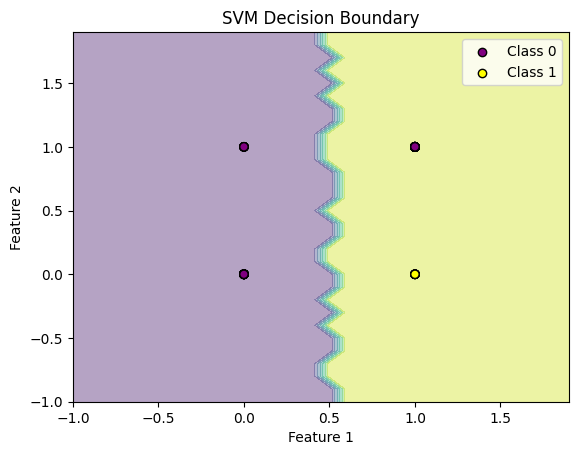

In [23]:
# Plotting the decision boundary
def plot_decision_boundary(X, y, clf):
    x_min, x_max = X.values[:, 0].min() - 1, X.values[:, 0].max() + 1
    y_min, y_max = X.values[:, 1].min() - 1, X.values[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)

    # Create a dictionary to map class labels to colors
    color_dict = {0: 'purple', 1: 'yellow', 2: 'green'}  # Add more colors as needed

    # Add legends for each class
    unique_classes = np.unique(y)
    for class_label in unique_classes:
        plt.scatter([], [], label=f'Class {class_label}', color=color_dict[class_label], edgecolor='k')
    plt.legend()

    # Plot data points with different colors for each class
    colors = [color_dict[label] for label in y]
    plt.scatter(X.values[:, 0], X.values[:, 1], c=colors, marker='o', edgecolor='k')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('SVM Decision Boundary')
    plt.show()

# Plotting the decision boundary on the testing set
plot_decision_boundary(X_test, y_test, cls)

In [29]:
y_pred = cls.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.723404255319149


In [30]:
y_pred = cls.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.712


### 2. Random Forest

In [59]:
# Initialize Decision Tree classifier
max_accuracy = []
for i in range(1,20):
    rf_classifier = RandomForestClassifier(n_estimators=200,max_depth=i).fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    max_accuracy.append(accuracy)
    #print('Max Depth: ' + str(i), "; Accuracy:", accuracy)
max_accu = max(max_accuracy)
print('Max Accuracy: ' + str(max_accu))
no_depth = max_accuracy.index(max_accu)+1
print('Best Depth: ' + str(no_depth))

Max Accuracy: 0.723404255319149
Best Depth: 1


In [34]:
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100,max_depth=no_tree)

# Train the Random Forest classifier
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=1)

In [35]:
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.723404255319149


In [36]:
y_pred = rf_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Train Accuracy:", accuracy)

Train Accuracy: 0.712


### 3. Decision Tree

In [58]:
# Initialize Decision Tree classifier
max_accuracy = []
for i in range(1,20):
    dt_classifier = DecisionTreeClassifier(max_depth=i).fit(X_train, y_train)
    y_pred = dt_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    max_accuracy.append(accuracy)
    #print('Max Depth: ' + str(i), "; Accuracy:", accuracy)
max_accu = max(max_accuracy)
print('Max Accuracy: ' + str(max_accu))
no_depth = max_accuracy.index(max_accu)+1
print('Best Depth: ' + str(no_depth))

Max Accuracy: 0.723404255319149
Best Depth: 1


In [41]:
dt_classifier = DecisionTreeClassifier(max_depth=no_tree).fit(X_train, y_train)

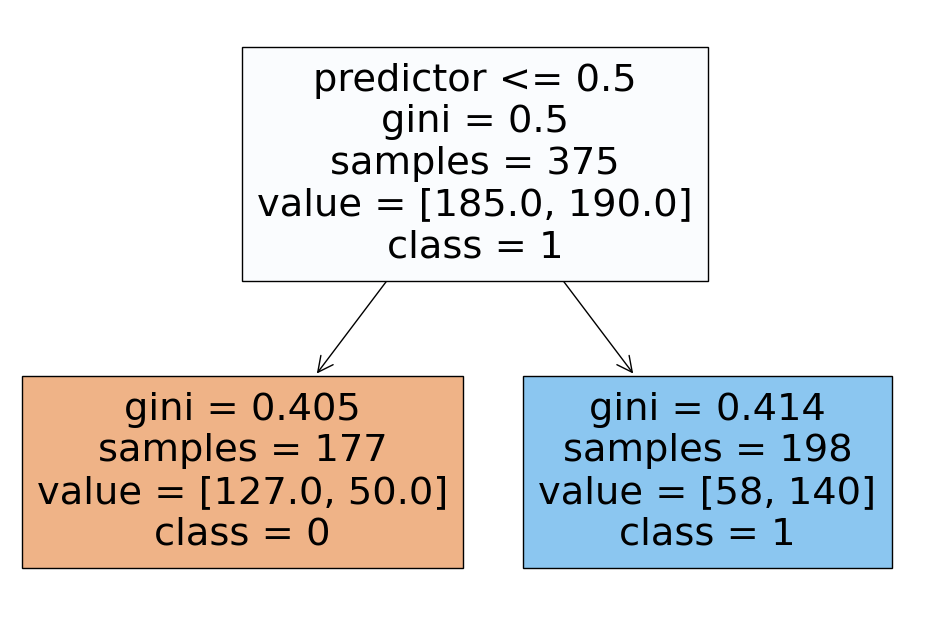

In [42]:
# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_classifier, filled=True, feature_names=features, class_names=['0','1'])
plt.show()

In [43]:
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.723404255319149


In [44]:
y_pred = dt_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Train Accuracy:", accuracy)

Train Accuracy: 0.712


# Backtesting

In [45]:
#df_test['Predicted_Signal'] = cls.predict(X_test)
#df_test['Predicted_Signal'] = rf_classifier.predict(X_test)
df_test['Predicted_Signal'] = dt_classifier.predict(X_test)

In [46]:
df_test['Return'] = df_test.Close.pct_change()

In [47]:
df_test['Strategy_Return'] = df_test.Return *df_test.Predicted_Signal.shift(1)

In [48]:
# Calculate Cumulutive returns 
df_test['Cum_Ret'] = df_test['Return'].cumsum() 
df_test

,Open,High,Low,Close,Adj Close,Volume,Heiken_Ashi,RSI,WMA,HL,...,Change,5_day_return,Open-Close,Change2,Candle,predictor,Predicted_Signal,Return,Strategy_Return,Cum_Ret
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-01,169.580002,172.710007,169.110001,169.300003,168.875214,50383100,0,39.346719,169.915924,3.600006,...,-0.604708,7.938572,0.279999,2.203187,1,1.0,1,NaN,NaN,NaN
2024-05-02,172.509995,173.419998,170.889999,173.029999,172.595856,94214900,1,43.964330,170.906769,2.529999,...,2.203187,6.669369,-0.520004,5.981625,0,1.0,1,0.022032,0.022032,0.022032
2024-05-03,186.649994,187.000000,182.660004,183.380005,182.919876,163224100,1,64.993001,177.137759,4.339996,...,5.981625,-0.179955,3.269989,-0.910676,1,1.0,1,0.059816,0.059816,0.081848
2024-05-06,182.350006,184.199997,180.419998,181.710007,181.254074,78569700,1,68.127028,180.366305,3.779999,...,-0.910676,2.514992,0.639999,0.379719,1,1.0,1,-0.009107,-0.009107,0.072741
2024-05-07,183.449997,184.899994,181.320007,182.399994,181.942337,77305800,1,71.608656,181.875839,3.579987,...,0.379719,2.757675,1.050003,0.186410,1,1.0,1,0.003797,0.003797,0.076539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-09,220.820007,221.270004,216.710007,220.910004,220.910004,67180000,0,39.202068,221.125005,4.559998,...,0.040756,-2.077768,-0.089996,-0.362140,0,0.0,0,0.000408,0.000000,0.278394
2024-09-10,218.919998,221.479996,216.729996,220.110001,220.110001,51591000,0,36.230626,220.495003,4.750000,...,-0.362140,-1.508340,-1.190002,1.158513,0,1.0,1,-0.003621,-0.000000,0.274773
2024-09-11,221.460007,223.089996,217.889999,222.660004,222.660004,44587100,1,42.718077,221.518336,5.199997,...,1.158513,-0.884758,-1.199997,0.049403,0,1.0,1,0.011585,0.011585,0.286358


In [49]:
df_test['Cum_Strategy'] = df_test['Strategy_Return'].cumsum() 
df_test

,Open,High,Low,Close,Adj Close,Volume,Heiken_Ashi,RSI,WMA,HL,...,5_day_return,Open-Close,Change2,Candle,predictor,Predicted_Signal,Return,Strategy_Return,Cum_Ret,Cum_Strategy
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-01,169.580002,172.710007,169.110001,169.300003,168.875214,50383100,0,39.346719,169.915924,3.600006,...,7.938572,0.279999,2.203187,1,1.0,1,NaN,NaN,NaN,NaN
2024-05-02,172.509995,173.419998,170.889999,173.029999,172.595856,94214900,1,43.964330,170.906769,2.529999,...,6.669369,-0.520004,5.981625,0,1.0,1,0.022032,0.022032,0.022032,0.022032
2024-05-03,186.649994,187.000000,182.660004,183.380005,182.919876,163224100,1,64.993001,177.137759,4.339996,...,-0.179955,3.269989,-0.910676,1,1.0,1,0.059816,0.059816,0.081848,0.081848
2024-05-06,182.350006,184.199997,180.419998,181.710007,181.254074,78569700,1,68.127028,180.366305,3.779999,...,2.514992,0.639999,0.379719,1,1.0,1,-0.009107,-0.009107,0.072741,0.072741
2024-05-07,183.449997,184.899994,181.320007,182.399994,181.942337,77305800,1,71.608656,181.875839,3.579987,...,2.757675,1.050003,0.186410,1,1.0,1,0.003797,0.003797,0.076539,0.076539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-09,220.820007,221.270004,216.710007,220.910004,220.910004,67180000,0,39.202068,221.125005,4.559998,...,-2.077768,-0.089996,-0.362140,0,0.0,0,0.000408,0.000000,0.278394,0.472656
2024-09-10,218.919998,221.479996,216.729996,220.110001,220.110001,51591000,0,36.230626,220.495003,4.750000,...,-1.508340,-1.190002,1.158513,0,1.0,1,-0.003621,-0.000000,0.274773,0.472656
2024-09-11,221.460007,223.089996,217.889999,222.660004,222.660004,44587100,1,42.718077,221.518336,5.199997,...,-0.884758,-1.199997,0.049403,0,1.0,1,0.011585,0.011585,0.286358,0.484241


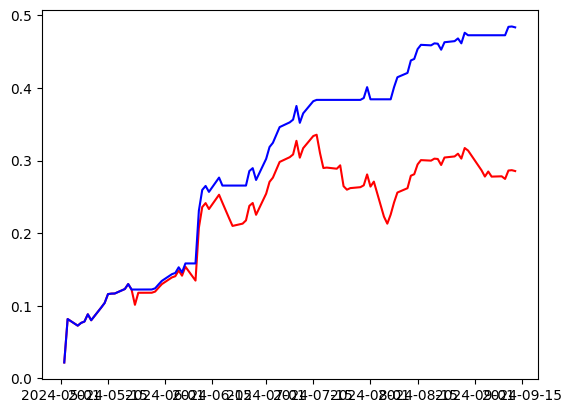

In [50]:
import matplotlib.pyplot as plt 
%matplotlib inline 

plt.plot(df_test['Cum_Ret'],color='red') 
plt.plot(df_test['Cum_Strategy'],color='blue')
